# 2a. 初始化参考数据

这本笔记本：
- 加载定义研究区域的多边形，然后为研究区域创建网格叠加。
- 加载参考数据。
- 处理参考数据以创建分析所需的网络结构和属性。

<div class="alert alert-block alert-info">
<b>先决条件和条件 输入/输出</b>
<p>
<span style="font-family:courier;">config.yml</span> 必须提前设置。
    
此笔记本的输出文件保存到 <span style="font-family:courier;">../data/REFERENCE/[study_area]/processed/</span> 子文件夹中，并在笔记本 2b、3a 和 3b 中使用。

当根据参考数据创建网络时，每条边都会分配一个唯一的边 ID。 要将边缘 ID 与原始数据中的 ID 相关联，请使用具有网络边缘的数据帧 <span style="font-family:courier;">ref_edges</span> 和 <span style="font-family:courier; ”ref_edges_simplified</span>，可以使用。
</p>
</div>

## 加载研究区域数据并创建分析网格

这一步：

- 从配置文件“config.yml”加载分析设置。
- 读取研究区域的数据。
- 创建研究区域的网格覆盖，网格单元大小在“config.yml”中定义。

<div class="alert alert-block alert-warning">
<b>Troubleshooting</b>
<p>
如果在下面的单元格中位于 <i>src</i> 文件夹中的函数未正确加载：检查 <span style="font-family:courier;">pip install -e .</span> 是否已运行 成功（请参阅 <span style="font-family:courier;">README.md</span> 中的说明）。
</p>
</div>

In [11]:
# Load libraries, settings and data

import pickle
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np

from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import simplification_functions as simp_func
from src import plotting_functions as plot_func

%run ../settings/plotting.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

warnings.filterwarnings("ignore")

### 加载研究区域的数据

研究区域由用户提供的多边形定义。 它将用于计算**全局**结果，即基于研究区域所有数据的质量指标。

In [12]:
# Read polygon for study area

study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print("Please assign a crs to the study area polygon!")

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f"The size of the study area is {area / 1000000:.2f} km2.")

The size of the study area is 181.38 km2.


This study area will be used for the analysis:


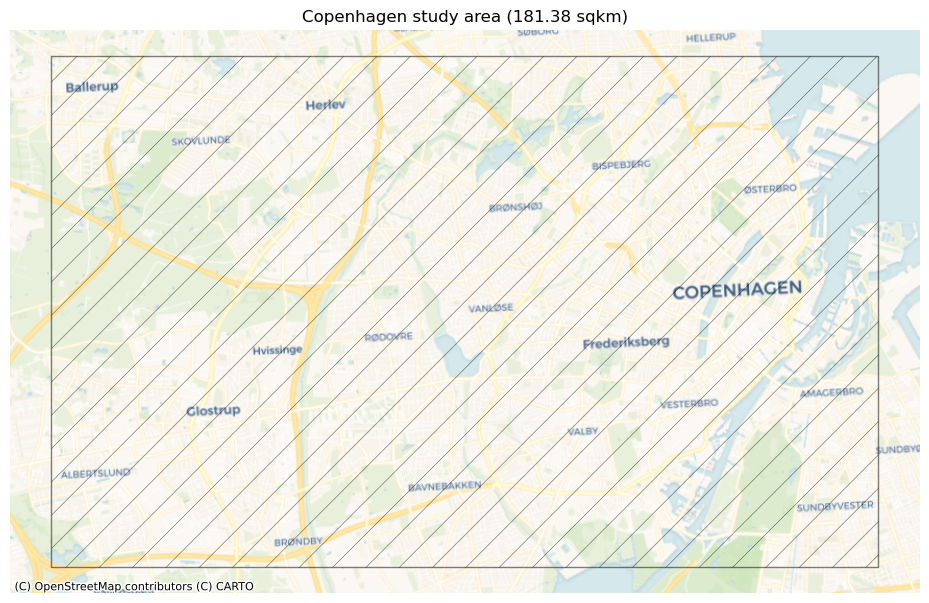

In [13]:
# Plot study area

set_renderer(renderer_map)
print("This study area will be used for the analysis:")

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
    
study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor='none',alpha=pdict["alpha_back"],hatch='/')

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(f"{area_name} study area ({area / 1000000:.2f} sqkm)")

plot_func.save_fig(fig, ref_results_static_maps_fp + "area_size_reference")

### 创建分析网格

<div class="alert alert-block alert-info">
<b>User configurations</b>
<p>
网格用于计算许多质量指标的<b>本地</b>结果，即网格单元级别。 网格单元的单元大小必须在配置文件中指定。 较小的网格单元会增加计算时间，但会给出更精细的结果。 网格单元大小不应小于您预期数据质量实际差异的比例。
</p>
</div>

The grid contains 2088 square cells with a side length of 300 m and an area of 0.09 km2.
This grid will be used for local (grid cell level) analysis:


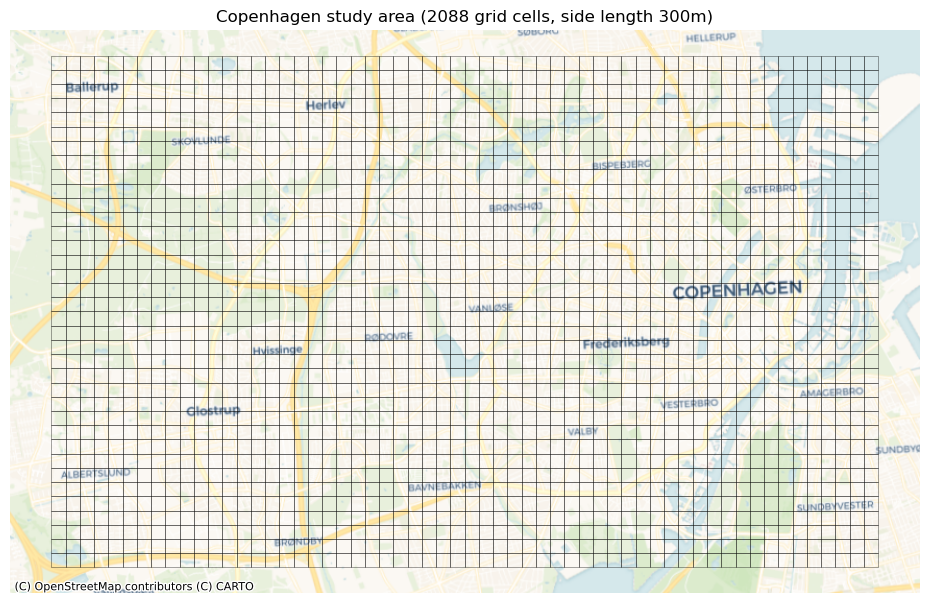

In [14]:
# Create and plot grid

set_renderer(renderer_map)
grid = eval_func.create_grid_geometry(study_area_poly, grid_cell_size)

grid["grid_id"] = grid.index

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

grid_cell_area = (grid_cell_size / 1000) ** 2  # in km2
print(
    f"The grid contains {len(grid)} square cells with a side length of {grid_cell_size} m and an area of {grid_cell_area:.2f} km2."
)
print("This grid will be used for local (grid cell level) analysis:")

grid.plot(ax=ax, facecolor="none", edgecolor=pdict["base"], alpha=pdict["alpha_back"],linewidth=0.5)

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)

ax.set_title(
    f"{area_name} study area ({len(grid)} grid cells, side length {grid_cell_size}m)"
)

plot_func.save_fig(fig, ref_results_static_maps_fp + "area_grid_reference")

## 加载并预处理参考数据

这一步：

- 根据参考数据创建网络。
- 将其投影到所选的 CRS。
- 将数据剪切到定义研究区域的多边形。
- 根据几何类型以及是否允许双向行进来测量边缘的基础设施长度。
- 简化网络。
- 创建由相交网格单元索引的所有边和节点数据集的副本。

**网络数据模型**

在 BikeDNA 中，所有输入数据都转换为由*节点*和*边*组成的网络结构。 边代表实际的基础设施，例如自行车道和路径，而节点代表边的起点和终点以及所有交叉路口。 有关更多详细信息，请阅读有关[网络数据模型](https://networkx.org/documentation/stable/reference/introduction.html)的更多信息。


<summary><b>网络简化</b></summary>

将一组线串转换为网络（图形）格式时，并非所有顶点（节点）都具有相同的含义。 对于边的几何形状，所有节点都用于定义边的形状。 然而，对于网络的拓扑，仅需要那些作为端点或与其他边的交点的节点，而所有其他（所谓的“间隙”）节点不添加任何信息。 为了比较网络中节点和边之间的结构和真实比率，需要简化的网络表示，仅包括端点和交叉点处的节点，或者重要属性值发生变化的位置。 简化网络的另一个优点是节点和边的数量大幅减少，这使得计算例程更快。

请注意，简化函数仅简化并合并具有相同重要属性（例如几何类型、自行车方向和保护级别）值的边。

<p align="center">
<img src='../../images/network_simplification_illustration.png' width=300/>

*非简化网络（左）和简化网络（右）*

</p>

作为简化例程的一部分，如果同一对节点之间存在多条边（“平行边”或“多重边”），则仅保留其中一条边。

要了解有关此处使用的修改后的 OSMnx 简化 [(Boeing, 2017)](https://geoffboeing.com/publications/osmnx-complex-street-networks/) 的更多信息，我们参考此 [GitHub repository](https://github.com/anerv/NERDS_osmnx)其中包含简化函数、逻辑解释和演示。



In [15]:
# Read reference data
org_ref_data = gpd.read_file(reference_fp)

# Create data with LineStrings only defined by end and start coordinate
ref_data = graph_func.unzip_linestrings(org_ref_data, reference_id_col)

# Create column with id called 'osmid'
ref_data["osmid"] = ref_data["new_edge_id"]
ref_data.drop(["new_edge_id"], axis=1, inplace=True)

# Reproject
if ref_data.crs == None:
    print("Please assign a crs to the study area polygon!")

if ref_data.crs != study_crs:
    ref_data = ref_data.to_crs(study_crs)

assert ref_data.crs == study_crs

# Clip reference data to study area poly
ref_data = ref_data.clip(study_area_poly)

ref_data = ref_data[ref_data.geometry.length!=0.0]

# Convert to osmnx graph object
graph_ref = graph_func.create_osmnx_graph(ref_data)

ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

# Overview of data
graph_area = eval_func.get_graph_area(ref_nodes, study_area_poly, study_crs)
print(
    f"The {reference_name} data covers an area of {graph_area / 1000000:.2f} km2."
)
print("\n")

# Classify edges as protected or unprotected
ref_edges = eval_func.define_protected_unprotected(
    ref_edges, ref_bicycle_infrastructure_type
)
for key, value in ref_edges.protected.value_counts().items():
    perc = np.round(100*value/len(ref_edges),2)
    print(f"Edges where the protection level is '{key}': {value} out of {len(ref_edges)} ({perc}%)")
print("\n")

# Summarize attribute values - if there are columns with values for each row instead of a global setting
if bicycle_bidirectional in ref_edges.columns:
    for key, value in ref_edges[bicycle_bidirectional].value_counts().items():
        perc = np.round(100*value/len(ref_edges),2)
        print(f"Edges where 'bicycle_bidirectional' is {key}: {value} out of {len(ref_edges)} ({perc}%)")
else: 
    print("Using global settings for cycling direction.")
print("\n")

if reference_geometries in ref_edges.columns:
    for key, value in ref_edges[reference_geometries].value_counts().items():
        perc = np.round(100*value/len(ref_edges),2)
        print(f"Edges where the geometry type is '{key}': {value} out of {len(ref_edges)}({perc}%)")
else:
    print("Using global settings for geometry type.")
print("\n")

# Add attributes to graph
protected_dict = ref_edges["protected"].to_dict()
nx.set_edge_attributes(graph_ref, protected_dict, "protected")

# Add 'multiple edge' attribute to each edge of the graph
for e in graph_ref.edges:
    graph_ref.edges[e]["multiedge"] = 0

# Count multiple edges and store info at key 0
# (simplification routine keeps only key 0)
for u, v, k in graph_ref.edges:
    if k > 0:
        graph_ref.edges[u, v, 0]["multiedge"] += 1

# Remove geometry attribute (required by simplification function)
for n1, n2, d in graph_ref.edges(data=True):
    d.pop("geometry", None)

# Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of bicycle infrastructure types
simplify_cols = [reference_geometries, bicycle_bidirectional, "protected"]
simplify_cols = [s for s in simplify_cols if s in ref_edges.columns]
graph_ref_simplified = simp_func.simplify_graph(
    graph_ref, attributes=simplify_cols, remove_rings=False
)

graph_ref = ox.get_undirected(graph_ref)
ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)
graph_ref_simplified = ox.get_undirected(graph_ref_simplified)

ref_nodes_simplified, ref_edges_simplified = ox.graph_to_gdfs(graph_ref_simplified)

ref_edges["length"] = ref_edges.geometry.length
ref_edges_simplified["length"] = ref_edges_simplified.geometry.length

# Measure the length of bicycle infrastructure (!=from length of edges)
if (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x[reference_geometries],
            bidirectional=x[bicycle_bidirectional],
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=x[bicycle_bidirectional],
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simplified["infrastructure_length"] = ref_edges_simplified.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x[reference_geometries],
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

else:
    print(
        f"Invalid data types for the variables reference_geometetries and/or bicycle_bidirectional!"
    )

print(
    f"The length of the {reference_name} network is {ref_edges_simplified.infrastructure_length.sum()/1000 :.2f} km."
)


# Creating coulumns with unique feature id (required by some functions)
ref_edges["edge_id"] = ref_edges.reset_index().index
ref_edges_simplified["edge_id"] = ref_edges_simplified.reset_index().index

ref_id_dict = ref_edges["edge_id"].to_dict()
nx.set_edge_attributes(graph_ref, ref_id_dict, "edge_id")

ref_id_dict_s = ref_edges_simplified["edge_id"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_id_dict_s, "edge_id")

# Saving data to graphs
ref_l_dict = ref_edges["length"].to_dict()
nx.set_edge_attributes(graph_ref, ref_l_dict, "length")

ref_l_dict_s = ref_edges_simplified["length"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_l_dict_s, "length")

ref_il_dict = ref_edges_simplified["infrastructure_length"].to_dict()
nx.set_edge_attributes(graph_ref_simplified, ref_il_dict, "infrastructure_length")

The GeoDanmark data covers an area of 169.76 km2.


Edges where the protection level is 'protected': 46097 out of 53580 (86.03%)
Edges where the protection level is 'unprotected': 7483 out of 53580 (13.97%)


Using global settings for cycling direction.


Using global settings for geometry type.


The length of the GeoDanmark network is 626.48 km.


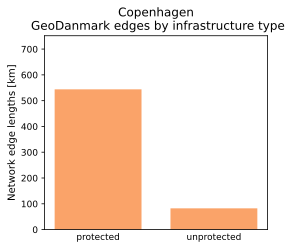

In [16]:
# Plot global statistics (by network length)

set_renderer(renderer_plot)
ymax = ref_edges.length.sum() * 1.2 /1000 # conversion m to km

# attribute: bidirectional
if bicycle_bidirectional in ref_edges.columns:
    
    x = []
    y = []

    for value in np.unique(ref_edges[bicycle_bidirectional]):
        x.append(str(value))
        y.append(ref_edges[ref_edges[bicycle_bidirectional]==value].length.sum()/1000) # conversion m to km

    plot_func.make_bar_plot(
        data = y,
        bar_labels = x,
        y_label = "Network edge lengths [km]",
        x_positions = [i for i in range(len(x))],
        title = f"{area_name}\n {reference_name} edges by bidirectionality",
        bar_colors = len(x)*[pdict["ref_base"]],
        filepath = ref_results_plots_fp + "edge_global_bidirectional",
        ylim = ymax,
        figsize=pdict["fsbar_small"]
    );

# attribute: protection
x = []
y = []

for value in np.unique(ref_edges.protected):
    x.append(value)
    y.append(ref_edges[ref_edges["protected"]==value].length.sum()/1000) # conversion m to km
    
plot_func.make_bar_plot(
    data = y,
    bar_labels = x,
    y_label = "Network edge lengths [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n {reference_name} edges by infrastructure type",
    bar_colors = len(x)*[pdict["ref_base"]],
    filepath = ref_results_plots_fp + "edge_global_infrastructuretype",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
);

# attribute: bicycle geometries (mapping type)
if reference_geometries in ref_edges.columns:

    x = []
    y = []

    for value in np.unique(ref_edges[reference_geometries]):
        x.append(value)
        y.append(ref_edges[ref_edges[reference_geometries]==value].length.sum()/1000) # conversion m to km

    plot_func.make_bar_plot(
        data = y,
        bar_labels = x,
        y_label = "Network edge lengths [km]",
        x_positions = [i for i in range(len(x))],
        title = f"{area_name}\n {reference_name} edges by mapping type",
        bar_colors = len(x)*[pdict["ref_base"]],
        filepath = ref_results_plots_fp + "edge_global_mappingtype",
        ylim = ymax,
        figsize=pdict["fsbar_small"]
    );

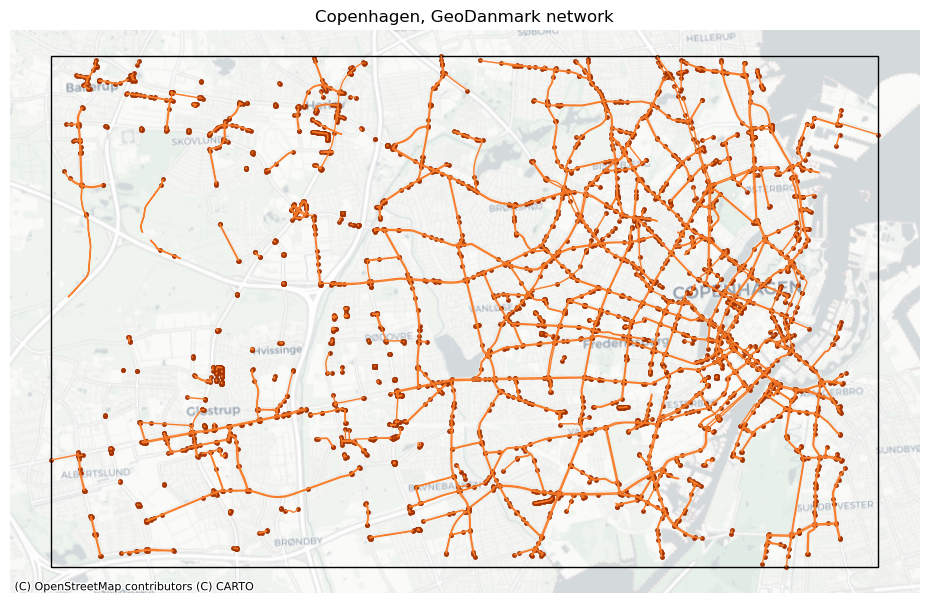

In [17]:
# Plot network

set_renderer(renderer_map)
fig, ax = plt.subplots(1, figsize=pdict["fsmap"])

ref_edges_simplified.plot(ax=ax, color=pdict["ref_base"], linewidth=pdict["line_base"])
ref_nodes_simplified.plot(ax=ax, color=pdict["ref_emp"], markersize=pdict["mark_emp"])

study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor="None", linewidth=1)

ax.set_axis_off()

cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_2)

ax.set_title(f"{area_name}, {reference_name} network")

plot_func.save_fig(fig, ref_results_static_maps_fp + "area_network_reference")

In [18]:
# Joining grid cell id to network elements

ref_edges_simp_joined = gpd.overlay(
    ref_edges_simplified.reset_index(), grid, how="intersection", keep_geom_type=True
)
ref_edges_joined = gpd.overlay(
    ref_edges.reset_index(), grid, how="intersection", keep_geom_type=True
)

ref_nodes_simp_joined = gpd.overlay(
    ref_nodes_simplified.reset_index(), grid, how="intersection", keep_geom_type=True
)
ref_nodes_joined = gpd.overlay(
    ref_nodes.reset_index(), grid, how="intersection", keep_geom_type=True
)

# Count features in each grid cell
all_data_ref = [
    ref_edges_joined,
    ref_nodes_joined,
    ref_edges_simp_joined,
    ref_nodes_simp_joined,
]
labels_ref = ["ref_edges", "ref_nodes", "ref_simplified_edges", "ref_simplified_nodes"]

for data, label in zip(all_data_ref, labels_ref):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")


# Recomputing infrastructure length for data joined to grid
ref_edges_simp_joined["length"] = ref_edges_simp_joined["geometry"].length

if (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=x[reference_geometries],
            bidirectional=x[bicycle_bidirectional],
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

elif (
    reference_geometries in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == str
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=reference_geometries,
            bidirectional=x[bicycle_bidirectional],
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )


elif (
    reference_geometries not in ["true_geometries", "centerline"]
    and type(bicycle_bidirectional) == bool
):

    ref_edges_simp_joined["infrastructure_length"] = ref_edges_simp_joined.apply(
        lambda x: eval_func.measure_infrastructure_length(
            edge=x.geometry,
            geometry_type=[reference_geometries],
            bidirectional=bicycle_bidirectional,
            bicycle_infrastructure="yes",
        ),
        axis=1,
    )

else:
    print(
        f"Invalid data types for the variables reference_geometries and/or bicycle_bidirectional!"
    )

assert round(ref_edges_simplified.infrastructure_length.sum() / 1000, 1) == round(
    ref_edges_simp_joined.infrastructure_length.sum() / 1000, 1
)

In [19]:
# Save reference data
exec(open("../settings/save_refdata.py").read())

GeoDanmark nodes and edges saved successfully!
GeoDanmark networks saved successfully!
Reference grid saved successfully!


***

In [20]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))

Time of analysis: Mon, 18 Dec 2023 20:19:22
